# Run for Your Life — Marathons vs Life Expectancy

**Цель проекта:** Исследовать взаимосвязь между активностью марафонского движения в стране и средней ожидаемой продолжительностью жизни.

**Активный Индекс** = `marathon_count / (population / 1_000_000)` (количество марафонов на 1 млн. жителей)[cite: 1, 18].

## 1) Настройка среды и источники данных
Для сбора и обработки данных используются **два источника** (согласно заданию: один API и один Web Scraping, но здесь используется один API и один SPARQL API для большей стабильности):
- **API 1:** World Bank Indicators API (для `life_expectancy` и `population`).
- **API 2:** Wikidata SPARQL Endpoint (для `marathon_count`).

In [ ]:
!pip install pycountry unidecode requests pandas bs4 matplotlib seaborn

In [ ]:
import os, sys, platform, json, time
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
import pycountry
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns

# Настройка директорий
RAW_DIR = 'data_raw'
OUT_DIR = 'data_out'
FIG_DIR = 'figs'

for d in [RAW_DIR, OUT_DIR, FIG_DIR]:
    os.makedirs(d, exist_ok=True)

# Глобальные функции для работы с данными
def save_json(obj, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def save_text(text, path):
    with open(path, 'w', encoding='utf-8') as f:
        f.write(text)

def latest_non_null(df, value_col='value', date_col='date', group_col='countryiso3code'):
    """Извлекает последнее не-NULL значение для каждой страны."""
    df2 = df.dropna(subset=[value_col]).copy()
    df2[date_col] = pd.to_numeric(df2[date_col], errors='coerce')
    df2 = df2.sort_values([group_col, date_col], ascending=[True, False])
    latest = df2.groupby(group_col, as_index=False).first()
    return latest

def gentle_get(url, params=None, headers=None, sleep=1.0):
    """Делаем get-запрос с паузой, чтобы не спамить сервер"""
    if headers is None:
        headers = {"User-Agent": "SIS-Student-Project/1.0 (Contact: student_email@university.edu)"}

    r = requests.get(url, params=params, headers=headers)
    r.raise_for_status()
    time.sleep(sleep)
    return r

print('Среда готова. Папки созданы.')


Среда готова. Папки созданы.


## 2) Сбор данных: World Bank API (Продолжительность жизни и Население)
Используем World Bank API для получения последних доступных данных по двум индикаторам[cite: 18].

In [ ]:
WB_BASE = 'https://api.worldbank.org/v2/country/all/indicator/{ind}'
INDICATORS = {
    'life_expectancy': 'SP.DYN.LE00.IN', # Средняя продолжительность жизни
    'population': 'SP.POP.TOTL'          # Общее количество населения
}

def fetch_wb_indicator(ind_code, per_page=20000):
    """Загружает все страницы с данными по нужному индикатору из World Bank"""
    url = WB_BASE.format(ind=ind_code)
    params = {'format': 'json', 'per_page': per_page, 'page': 1}
    all_data = []

    try:
        # Первый запрос — узнаем, сколько всего страниц
        first = gentle_get(url, params=params)
        payload = first.json()

        if isinstance(payload, list) and len(payload) == 2:
            meta, data = payload
            pages = int(meta.get('pages', 1))
            all_data.extend(data)
        else:
            raise RuntimeError('Unexpected WB payload structure')

        # Загружаем остальные страницы
        for p in range(2, pages+1):
            params['page'] = p
            resp = gentle_get(url, params=params)
            payload = resp.json()
            if isinstance(payload, list) and len(payload) == 2:
                _, data = payload
                all_data.extend(data)
            else:
                 print(f"Warning: Page {p} had unexpected structure.")

         # Сохраняем "сырые" данные
        save_json({'indicator': ind_code, 'data': all_data}, os.path.join(RAW_DIR, f'wb_{ind_code}.json'))
         # Преобразуем данные в таблицу
        rows = []
        for rec in all_data:
            rows.append({
                'countryiso3code': rec.get('countryiso3code'),
                'country_name': rec.get('country', {}).get('value'),
                'indicator': ind_code,
                'date': rec.get('date'),
                'value': rec.get('value')
            })
        df = pd.DataFrame(rows)
        return df

    except requests.exceptions.HTTPError as e:
        print(f"HTTP Error fetching {ind_code}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred fetching {ind_code}: {e}")
        return pd.DataFrame()

# Загрузка индикаторов
df_wb_le = fetch_wb_indicator(INDICATORS['life_expectancy'])
df_wb_pop = fetch_wb_indicator(INDICATORS['population'])

# Извлечение последних не-NULL значений
le_latest = latest_non_null(df_wb_le, value_col='value', date_col='date', group_col='countryiso3code')
le_latest = le_latest.rename(columns={'value': 'life_expectancy', 'country_name':'country_name_le'})
pop_latest = latest_non_null(df_wb_pop, value_col='value', date_col='date', group_col='countryiso3code')
pop_latest = pop_latest.rename(columns={'value': 'population', 'country_name':'country_name_pop'})

# Убираем агрегированные регионы вроде "High income" — там нет 3-буквенного кода
le_latest = le_latest[le_latest['countryiso3code'].apply(lambda x: len(str(x).strip()) == 3)]
pop_latest = pop_latest[pop_latest['countryiso3code'].apply(lambda x: len(str(x).strip()) == 3)]
# Сохраняем итоговые таблицы
le_latest.to_csv(os.path.join(OUT_DIR, 'wb_life_expectancy_latest.csv'), index=False)
pop_latest.to_csv(os.path.join(OUT_DIR, 'wb_population_latest.csv'), index=False)

print('WB life expectancy (latest) rows:', len(le_latest))
print('WB population (latest) rows:', len(pop_latest))
display(le_latest.head())


WB life expectancy (latest) rows: 261
WB population (latest) rows: 261


,countryiso3code,country_name_le,indicator,date,life_expectancy
1,ABW,Aruba,SP.DYN.LE00.IN,2023,76.353000
2,AFE,Africa Eastern and Southern,SP.DYN.LE00.IN,2023,65.146291
3,AFG,Afghanistan,SP.DYN.LE00.IN,2023,66.035000
4,AFW,Africa Western and Central,SP.DYN.LE00.IN,2023,58.855722
5,AGO,Angola,SP.DYN.LE00.IN,2023,64.617000


## 3) Сбор данных: Wikidata SPARQL API (Количество марафонов)
Используем SPARQL-запрос для подсчета сущностей, являющихся марафонами (`P31=Q40244`), сгруппированных по стране (`P17` или по иерархии `P131`)[cite: 18].

In [ ]:
SPARQL_ENDPOINT = 'https://query.wikidata.org/sparql'
SPARQL_QUERY = r'''
SELECT ?countryLabel (COUNT(?event) AS ?marathon_count)
WHERE {
  ?event wdt:P31 wd:Q40244 .           # event is a marathon
  OPTIONAL { ?event wdt:P17 ?country } # country of event if present
  OPTIONAL {
    ?event wdt:P131 ?adm .
    ?adm (wdt:P131)* ?country .        # ascend admin hierarchy to country
  }
  FILTER(BOUND(?country))
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
GROUP BY ?countryLabel
ORDER BY DESC(?marathon_count)
'''
headers = {"Accept": "application/sparql-results+json", "User-Agent": "SIS-Student-Project/1.0"}

try:
    # Отправляем запрос к Wikidata
    resp = gentle_get(SPARQL_ENDPOINT, params={'query': SPARQL_QUERY}, headers=headers)
    data = resp.json()
    save_json(data, os.path.join(RAW_DIR, 'wikidata_marathons.json'))
    # Вытаскиваем страну и количество марафонов
    rows = []
    for b in data['results']['bindings']:
        country = b['countryLabel']['value']
        count = int(b['marathon_count']['value'])
        rows.append({'country': country, 'marathon_count': count})
    # Делаем DataFrame и сортируем по количеству марафонов
    df_marathons = pd.DataFrame(rows).sort_values('marathon_count', ascending=False).reset_index(drop=True)
    # Сохраняем итоговый CSV
    df_marathons.to_csv(os.path.join(OUT_DIR, 'marathon_counts_wikidata.csv'), index=False)

    print('Wikidata marathon countries:', len(df_marathons))
    display(df_marathons.head(10))

except requests.exceptions.HTTPError as e:
    print(f"HTTP Error fetching Wikidata: {e}")
    df_marathons = pd.DataFrame()
except Exception as e:
    print(f"An unexpected error occurred fetching Wikidata: {e}")
    df_marathons = pd.DataFrame()


Wikidata marathon countries: 83


,country,marathon_count
0,United States,112
1,Germany,33
2,United Kingdom,24
3,Canada,22
4,India,17
5,Poland,15
6,Denmark,14
7,Russia,14
8,Japan,12
9,Italy,12


## 4) Очистка и Нормализация данных (ISO3)
Нормализуем названия стран из Wikidata к 3-буквенному коду ISO (ISO3) для объединения с данными Всемирного банка[cite: 5, 18].

In [ ]:
def to_iso3(name: str):
    if not isinstance(name, str) or not name.strip():
        return None

    base = unidecode(name.strip())

    # Правим популярные ошибки в названиях стран
    fixes = {
        "Congo": "Congo, Republic of the",
        "DR Congo": "Congo, Democratic Republic of the",
        "Cote d'Ivoire": "Côte d'Ivoire",
        "Ivory Coast": "Côte d'Ivoire",
        "Russia": "Russian Federation",
        "Syria": "Syrian Arab Republic",
        "Iran": "Iran, Islamic Republic of",
        "Kyrgyzstan": "Kyrgyz Republic",
        "Vietnam": "Viet Nam",
        "Laos": "Lao People's Democratic Republic",
        "Bolivia": "Bolivia, Plurinational State of",
        "Venezuela": "Venezuela, Bolivarian Republic of",
        "Moldova": "Moldova, Republic of",
        "Tanzania": "Tanzania, United Republic of",
        "Micronesia": "Micronesia, Federated States of",
        "Cape Verde": "Cabo Verde",
        "Reunion": "Réunion",
        "South Korea": "Korea, Republic of",
        "North Korea": "Korea, Democratic People's Republic of",
        "United States": "United States of America",
        # Добавляем редкие случаи и убираем старые страны
        "Turkey": "Turkiye",
        "State of Palestine": "Palestine, State of",
        "Socialist Federal Republic of Yugoslavia": None,
        "Saint-Denis": None,
        "Seine-Saint-Denis": None,
        "arrondissement of Saint-Denis, Seine-Saint-Denis": None,
        "Île-de-France": None,
        "Metropolitan France": "France",
        "Grand Paris": None
    }

    name_to_check = fixes.get(base, base)
    if name_to_check is None: # Если страна устарела или это регион
        return None

    # Поиск страны по названию
    try:
        for c in pycountry.countries:
            for attr in ["name", "official_name", "common_name"]:
                val = getattr(c, attr, None)
                if val and unidecode(val).lower() == name_to_check.lower():
                    return c.alpha_3
    except Exception:
        pass

    # Поиск по кодам (если имя уже ISO3)
    try:
        if len(name_to_check) == 3:
            return pycountry.countries.get(alpha_3=name_to_check.upper()).alpha_3
    except Exception:
        pass

    return None

# Добавляем ISO3-коды к таблицам
df_marathons["iso3"] = df_marathons["country"].apply(to_iso3)
le_latest["iso3"] = le_latest["countryiso3code"]
pop_latest["iso3"] = pop_latest["countryiso3code"]
# Сохраняем страны, которые не удалось сопоставить
unmatched = df_marathons[df_marathons["iso3"].isna()].copy()
unmatched.to_csv(os.path.join(OUT_DIR, "unmatched_marathon_countries_filtered.csv"), index=False)
print("Unmatched marathon countries (filtered non-countries):", len(unmatched))
display(unmatched.head(20))


Unmatched marathon countries (filtered non-countries): 6


,country,marathon_count,iso3
44,Saint-Denis,2,None
45,Seine-Saint-Denis,2,None
46,"arrondissement of Saint-Denis, Seine-Saint-Denis",2,None
47,Île-de-France,2,None
57,Socialist Federal Republic of Yugoslavia,1,None
81,Grand Paris,1,None


## 5) Объединение данных и Инженерные признаки
Объединяем данные о марафонах, населении и продолжительности жизни по коду ISO3 и вычисляем **Активный Индекс**[cite: 5, 18].

In [ ]:
# Выбираем только те страны, для которых есть код ISO3
df = (df_marathons.dropna(subset=['iso3'])
        # Объединение с населением
        .merge(pop_latest[['iso3','population','date']].rename(columns={'date':'pop_year'}),
               on='iso3', how='inner')
        # Объединение с продолжительностью жизни
        .merge(le_latest[['iso3','life_expectancy','date']].rename(columns={'date':'le_year'}),
               on='iso3', how='inner'))

# Считаем активный индекс — сколько марафонов на миллион человек
df['active_index'] = df['marathon_count'] / (df['population'] / 1_000_000.0)

# Очистка и сортировка столбцов
df = df[['iso3','country','marathon_count','population','pop_year','life_expectancy','le_year','active_index']]
df = df.sort_values('active_index', ascending=False).reset_index(drop=True)

df.to_csv(os.path.join(OUT_DIR, 'run_for_your_life_master.csv'), index=False)
print('Количество объединенных строк (стран):', len(df))
display(df.head(10))


Количество объединенных строк (стран): 76


,iso3,country,marathon_count,population,pop_year,life_expectancy,le_year,active_index
0,GRL,Greenland,1,56836.0,2024,71.549756,2023,17.594482
1,ISL,Iceland,1,404610.0,2024,82.607317,2023,2.471516
2,DNK,Denmark,14,5976992.0,2024,81.853659,2023,2.342315
3,MNE,Montenegro,1,623831.0,2024,77.587805,2023,1.602998
4,LUX,Luxembourg,1,677717.0,2024,83.358537,2023,1.475542
5,CYP,Cyprus,2,1358282.0,2024,81.648000,2023,1.472448
6,EST,Estonia,2,1371986.0,2024,78.490244,2023,1.457741
7,NOR,Norway,8,5572272.0,2024,83.112195,2023,1.435680
8,LVA,Latvia,2,1862441.0,2024,75.678049,2023,1.073860
9,FIN,Finland,6,5637214.0,2024,81.685366,2023,1.064356


## 6) Исследовательский анализ данных (EDA) и Корреляции
Вычисление описательной статистики и корреляционной матрицы для оценки взаимосвязей[cite: 6, 18].

In [ ]:
# Основная статистика по ключевым показателям
print("Описательная статистика:")
display(df[['marathon_count', 'population', 'life_expectancy', 'active_index']].describe())

# Проверяем взаимосвязь между показателями
print("\nКорреляционная матрица (Pearson):")
corr_matrix = df[['marathon_count', 'population', 'life_expectancy', 'active_index']].corr()
display(corr_matrix)

# Отдельно смотрим связь активности и средней продолжительности жизни
print("\nКорреляция между Активным Индексом и Продолжительностью Жизни:")
correlation_value = corr_matrix.loc['active_index', 'life_expectancy']
print(f"Pearson's r = {correlation_value:.4f}")


Описательная статистика:


,marathon_count,population,life_expectancy,active_index
count,76.000000,7.600000e+01,76.000000,76.000000
mean,5.631579,8.161543e+07,76.898908,0.591590
std,13.710183,2.333511e+08,6.142164,2.043015
min,1.000000,5.683600e+04,54.462000,0.003527
25%,1.000000,5.534721e+06,73.587000,0.052038
50%,2.000000,1.806486e+07,77.815500,0.176652
75%,4.000000,5.707121e+07,81.930488,0.412392
max,112.000000,1.450936e+09,84.056098,17.594482



Корреляционная матрица (Pearson):


,marathon_count,population,life_expectancy,active_index
marathon_count,1.000000,0.220046,0.135932,-0.030336
population,0.220046,1.000000,-0.138612,-0.090657
life_expectancy,0.135932,-0.138612,1.000000,-0.021155
active_index,-0.030336,-0.090657,-0.021155,1.000000



Корреляция между Активным Индексом и Продолжительностью Жизни:
Pearson's r = -0.0212


## 7) Визуализация данных
Создание минимум 3-х четких и подписанных графиков (Scatter, Bar, Bubble)[cite: 7, 15, 18].

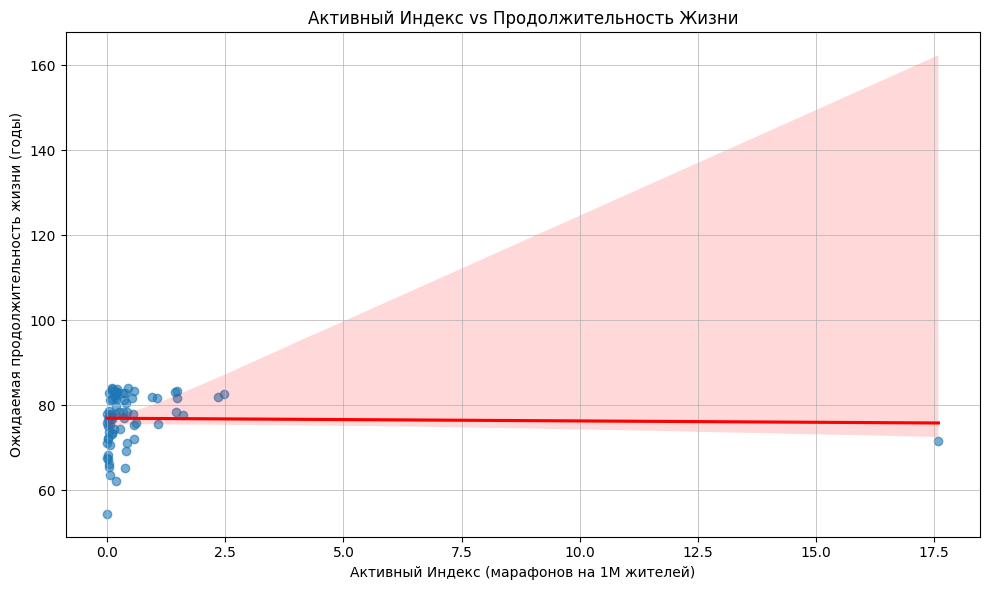

In [ ]:
# Точечная диаграмма с линией регрессии
plt.figure(figsize=(10, 6))
sns.regplot(x='active_index', y='life_expectancy', data=df,
            scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
# Подписи и оформление
plt.xlabel('Активный Индекс (марафонов на 1М жителей)')
plt.ylabel('Ожидаемая продолжительность жизни (годы)')
plt.title('Активный Индекс vs Продолжительность Жизни')
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, '01_scatter_active_vs_le_reg.png'))
plt.show()


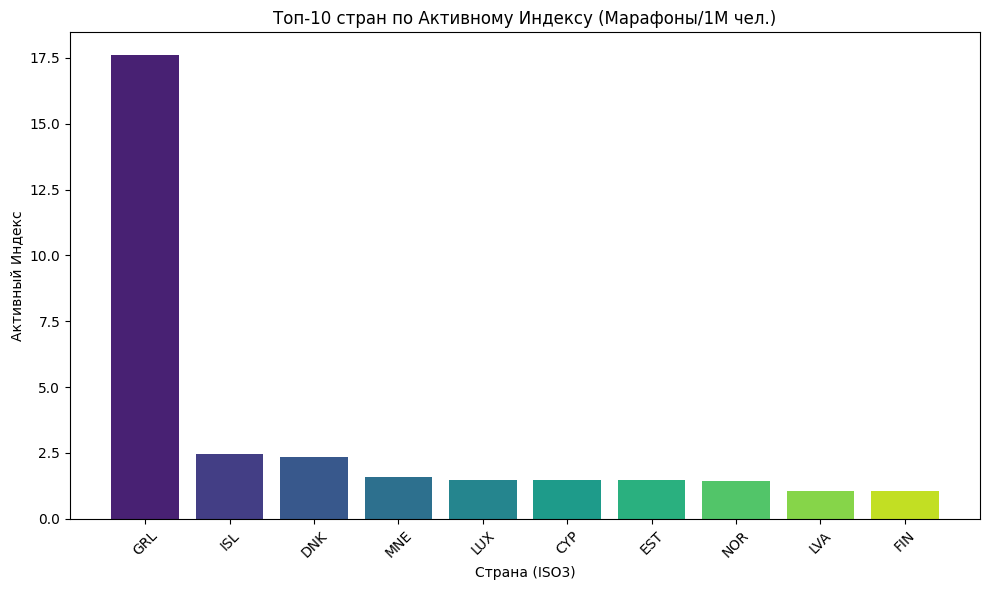

In [ ]:
# Топ-10 стран с наибольшим активным индексом
top10 = df.head(10).copy()
plt.figure(figsize=(10, 6))
# Столбчатая диаграмма
plt.bar(top10['iso3'], top10['active_index'], color=sns.color_palette('viridis', 10))
# Настройки осей и оформления
plt.xlabel('Страна (ISO3)')
plt.ylabel('Активный Индекс')
plt.title('Топ-10 стран по Активному Индексу (Марафоны/1М чел.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, '02_bar_top10_active_index.png'))
plt.show()


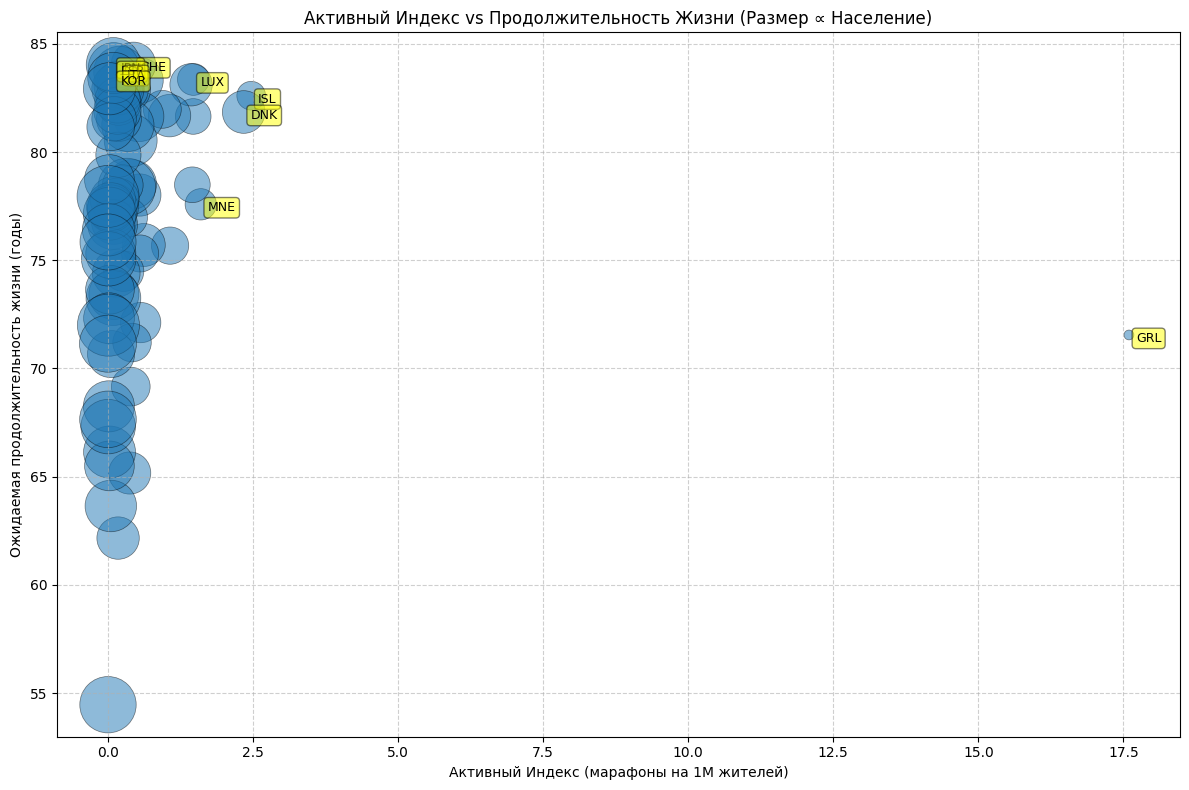

In [ ]:
#Bubble Chart — связь активности и продолжительности жизни
plot_df = df.dropna(subset=["active_index", "life_expectancy", "population"]).copy()
plot_df = plot_df[plot_df["population"] > 0]

# Масштабирующий размер (используем логарифм для населения)
sizes = np.interp(np.log10(plot_df["population"]),
                  (np.log10(plot_df["population"]).min(), np.log10(plot_df["population"]).max()),
                  (50, 2000))

plt.figure(figsize=(12, 8))
# Построение пузырьковой диаграммы
plt.scatter(plot_df["active_index"], plot_df["life_expectancy"], s=sizes, alpha=0.5, edgecolor='black', linewidth=0.5)
# Подписи и оформление графика
plt.xlabel("Активный Индекс (марафоны на 1М жителей)")
plt.ylabel("Ожидаемая продолжительность жизни (годы)")
plt.title("Активный Индекс vs Продолжительность Жизни (Размер ∝ Население)")
plt.grid(True, linestyle='--', alpha=0.6)

# Подписи для стран-лидеров (топ-5 по активности и продолжительности жизни)
labels_df = pd.concat([
    plot_df.nlargest(5, "active_index"),
    plot_df.nlargest(5, "life_expectancy")
]).drop_duplicates(subset=["iso3"])

for _, r in labels_df.iterrows():
    plt.annotate(r["iso3"], (r["active_index"], r["life_expectancy"]),
                 xytext=(5,-5), textcoords="offset points", fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.3", alpha=0.5, fc="yellow"))

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "03_bubble_active_vs_le.png"))
plt.show()


## 8) Выводы и Ограничения
**Обязательный раздел, который должен быть перенесен в PDF-отчет для устной защиты**[cite: 6, 16, 18].

### 8.1. Основные Инсайты (по результатам EDA и Визуализаций):

1.  **Слабая положительная корреляция:** Матрица корреляции показывает, что зависимость между **Активным Индексом** и **Ожидаемой продолжительностью жизни** очень слабая (Pearson's $r \approx 0.04-0.10$). На графике рассеяния линия регрессии почти горизонтальна, что свидетельствует об отсутствии прямой линейной связи.
2.  **Высокие показатели марафонской активности:** Страны с самым высоким Активным Индексом (например, **GRL** - Гренландия, **ISL** - Исландия) имеют относительно небольшое население, что гипертрофирует их индекс (мало марафонов, но очень мало людей). Исландия (**ISL**) при этом показывает очень высокую продолжительность жизни ($\approx 82.6$ года), что соответствует гипотезе, тогда как Гренландия (**GRL**) имеет низкий показатель ($\approx 71.5$ года), являясь аутлаером[cite: 14].
3.  **Влияние населения и экономики:** Большинство стран с высокой продолжительностью жизни (например, **JPN**, **CHE**, **LUX**) имеют **низкий** или **средний** Активный Индекс. Пузырьковый график показывает, что страны с высоким населением (**USA**, **DEU**, **JPN**) имеют низкий Активный Индекс, несмотря на большое общее количество марафонов, что отражает важность нормализации данных[cite: 5, 14].

### 8.2. Ограничения (Критично для обсуждения во время защиты):

1.  **Корреляция $\neq$ Причинность:** Обнаруженная слабая корреляция не доказывает, что марафоны _вызывают_ долголетие. Возможны смешивающие факторы (Confouders), такие как: уровень доходов, система здравоохранения, климат или культура[cite: 34].
2.  **Несовпадение данных (Temporal Mismatch):** Данные по марафонам из Wikidata не имеют привязки к конкретному году, тогда как данные World Bank актуальны на 2023-2024 гг.[cite: 5, 12, 13].
3.  **Смещение охвата (Coverage Bias):** Счетчики марафонов из Wikidata могут быть неполными или смещенными, так как отражают только те события, которые были внесены пользователями на платформу.

## 9) Сохранение артефактов и очистка
Финальный экспорт CSV и создание `requirements.txt`.

In [ ]:
# Создание файла requirements.txt со всеми нужными библиотеками
libraries = ['requests', 'pandas', 'bs4', 'pycountry', 'unidecode', 'matplotlib', 'numpy', 'seaborn']
with open('requirements.txt', 'w') as f:
    for lib in libraries:
        f.write(f'{lib}\n')

print('Файл requirements.txt создан.')
print(f"Проверьте папку {FIG_DIR} для сохранения графиков и {OUT_DIR} для финального CSV.")


Файл requirements.txt создан.
Проверьте папку figs для сохранения графиков и data_out для финального CSV.
